#### Practical strategies for ships passing limited water depth to achieve multiple goals
- Strategies include vessel sailing velocities, payload adjustment(actual draught), parcial engine load
- multiple goals covers the indicators of fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway). 

##### Steps
- present a waterway section with limited water depth (150 km with 2.5 m water depth) on the graph
- provide a list of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
- use get_v funtion to get maximum feasible velocity considering both installed enegine power and ship squat while moving at a speed
- for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
- use 'Parallel coordinate plot' to visualise strategies
- Automatically select optimal strategies to achieve the goal of less transport time, less emissions, less fuel use, safety guarantees.

In [1]:

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling

import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# Used for mathematical functions
import math             

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

# Used for making the graph
import networkx as nx

# OpenTNSim
import opentnsim


#### Present the waterway section with limited water depth on the graph network

In [2]:
# We're in engineering cordinates (m)
coords = [
    [0,0],
    [0.08983*500,0]] 


# these are the indices of the points above
edge_indices = [
    [0, 1]
]

depths = [18] 

widths = [300]

points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

In [3]:
# define Site class
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

In [4]:
FG = nx.DiGraph()

nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": str(index), "geometry": shapely.geometry.Point(points[index].x, points[index].y)}
    nodes.append(Node(**data_node))

for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)    
    
for index, edge in enumerate(edge_indices):
    edge_geometry = shapely.geometry.LineString([points[edge[0]], points[edge[1]]])
    edge_properties = dict(
        GeneralDepth = depths[index],
        width = widths[index],
        geometry = edge_geometry, 
        length = round(edge_geometry.length),
        e = tuple(edge)
    )
    FG.add_edge( str(edge[0]), str(edge[1]), weight = 1, Info = edge_properties)

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [5]:
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)

In [6]:
# collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

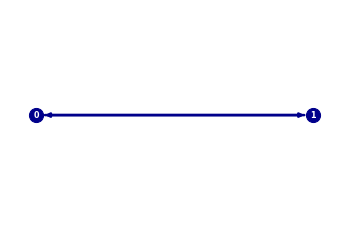

In [7]:
# draw edges, nodes and labels.
colors =['darkblue']
nx.draw_networkx_edges(FG,  pos=positions, width=2.5, edge_color=colors, alpha=1, arrowsize=8)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=200)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="white")

plt.axis("off")
plt.savefig('graph_dredging.pdf', bbox_inches = 'tight', dpi=600, format='pdf') 
plt.show()

#### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [8]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [9]:
# Create a dict with all important settings
data_vessel = {
               "env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type":  None, # <-- note that inputs from hereon are due to the added mixins!
               "B": 36.2,
               "L": 190,
               "H_e": None, 
               "H_f": None, 
               "T": 14,
               "safety_margin": 0.2, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat":True,
               "P_installed": 37060, # kW  
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to none; otherwise set to 1.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2,# number of propellers
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":2000,
              }        
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

#### Provide a group of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
here we choose M8 vessel as it has a large share of the sailing movements per year on waal (Rijkswaterstaat,2021, Safety aspects of new energy carriers in inland navigation), M8's draught ranges from 1.4 m to 3.5 m, considering a safety margin (minimum ukc) of 0.2 m at water depth 2.5 m, the final feasible draught ranges from 1.4 m to 2.3 m.

In [10]:
# provide max and min draught
max_draught = 14
min_operational_draught = 6
stepsize = -1

# create lists of strategy values
T_strategy = np.arange(max_draught, round(min_operational_draught + stepsize, 2), stepsize).round(2).tolist()
h_min = [18]
safety_margin = [0.2]
width = [300]


In [11]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product(T_strategy, h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T_strategy": item[0],"h_min":item[1], "safety_margin":item[2], "width":item[3]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(20)

,T_strategy,h_min,safety_margin,width
0,14,18,0.2,300
1,13,18,0.2,300
2,12,18,0.2,300
3,11,18,0.2,300
4,10,18,0.2,300
5,9,18,0.2,300
6,8,18,0.2,300
7,7,18,0.2,300
8,6,18,0.2,300


#### Caculate the maximum velocity the vessel can sail at for each T_strategy, considering maximum sinkage and installed engine power

In [12]:
Strategies = []

for i, row in tqdm.tqdm(work_df.iterrows(),disable=True):

    # get vessel 
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T_strategy']
    vessel.safety_margin = row['safety_margin']
    
    # estimate 'grounding speed' as a useful upperbound
    upperbound, selected, results_df = opentnsim.strategy.get_upperbound_for_power2v(vessel, width=row['width'], depth=row['h_min'], margin=0)
    
    # calculate the velocity that belongs to the T_strategy (while leaving the margin)
    v, depth, depth_squat, z_computed, margin = opentnsim.strategy.get_v(vessel, width=row['width'], depth=row['h_min'], margin=row['safety_margin'], bounds=(0, upperbound))
    
    # detaremine payload
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    
    Strategy ={}
    Strategy.update(row)
    Strategy['v_upper_bound (m/s)'] = upperbound # power allowed max v   
    Strategy['v_strategy (m/s)'] = v  # final max v considering squat and installed power
    Strategy['z_computed (m)'] = z_computed
    Strategy['depth squat (m)'] = depth_squat
    Strategy['T + margin (m)'] = row['T_strategy']+ row['safety_margin']
    
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted
    Strategies.append(Strategy)

In [13]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df)

,T_strategy,h_min,safety_margin,width,v_upper_bound (m/s),v_strategy (m/s),z_computed (m),depth squat (m),T + margin (m),Payload_strategy_tanker (ton)
0,14.00,18.00,0.20,300.00,8.73,8.73,2.25,15.75,14.20,53805.19
1,13.00,18.00,0.20,300.00,8.93,8.93,2.22,15.78,13.20,53805.19
2,12.00,18.00,0.20,300.00,9.01,9.01,2.12,15.88,12.20,53805.19
3,11.00,18.00,0.20,300.00,9.03,9.03,1.99,16.01,11.20,53805.19
4,10.00,18.00,0.20,300.00,9.07,9.07,1.85,16.15,10.20,53805.19
5,9.00,18.00,0.20,300.00,9.10,9.10,1.71,16.29,9.20,53805.19
6,8.00,18.00,0.20,300.00,9.10,9.10,1.56,16.44,8.20,52628.04
7,7.00,18.00,0.20,300.00,9.30,9.30,1.46,16.54,7.20,45412.78
8,6.00,18.00,0.20,300.00,9.30,9.30,1.29,16.71,6.20,38458.20


#### Provide a group of feasible velocities for each T_strategy

In [14]:
# provide max and min draught
v_feasible_forT = []
for row in Strategies:
    max_velocity = row['v_strategy (m/s)']
    min_velocity = 3
    stepsize = -1
    # create lists of strategy values
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2).tolist()
    v_feasible_forT.append(v_feasible)
v_df = pd.DataFrame(v_feasible_forT).T
names=['T=14','T=13','T=12','T=11','T=10','T=9','T=8','T=7','T=6']
v_df.columns=names
v_df

,T=14,T=13,T=12,T=11,T=10,T=9,T=8,T=7,T=6
0,8.73,8.93,9.01,9.03,9.07,9.1,9.1,9.3,9.3
1,7.73,7.93,8.01,8.03,8.07,8.1,8.1,8.3,8.3
2,6.73,6.93,7.01,7.03,7.07,7.1,7.1,7.3,7.3
3,5.73,5.93,6.01,6.03,6.07,6.1,6.1,6.3,6.3
4,4.73,4.93,5.01,5.03,5.07,5.1,5.1,5.3,5.3
5,3.73,3.93,4.01,4.03,4.07,4.1,4.1,4.3,4.3
6,2.73,2.93,3.01,3.03,3.07,3.1,3.1,3.3,3.3
7,NaN,NaN,2.01,2.03,2.07,2.1,2.1,2.3,2.3


In [15]:
# create a new table of all the v/strategy combinations
# using the itertools.product is more pro
# but for now we'll just loop
rows = []
for strategy in Strategies:
    max_velocity = strategy['v_strategy (m/s)']
    min_velocity = 1
    stepsize = -0.1
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2)
    for v_feasible_i in v_feasible:
        row = {}
        row.update(strategy)
        row['max_velocity'] = max_velocity
        row['min_velocity'] = min_velocity
        row['stepsize'] = stepsize
        row['v_feasible'] = v_feasible_i
       
        rows.append(row)
v_flat_df = pd.DataFrame(rows)        

    

In [16]:
columns = ['T_strategy', 'v_feasible', 'h_min', 'safety_margin', 'width']
# select relevant info
# these are all the runs that we want to run a simulation 
runs_df = v_flat_df[columns]
runs_df

,T_strategy,v_feasible,h_min,safety_margin,width
0,14.0,8.73,18.0,0.2,300.0
1,14.0,8.63,18.0,0.2,300.0
2,14.0,8.53,18.0,0.2,300.0
3,14.0,8.43,18.0,0.2,300.0
4,14.0,8.33,18.0,0.2,300.0
...,...,...,...,...,...
733,6.0,1.40,18.0,0.2,300.0
734,6.0,1.30,18.0,0.2,300.0
735,6.0,1.20,18.0,0.2,300.0
736,6.0,1.10,18.0,0.2,300.0


In [17]:
# import IPython.display

# T_strategies = v_flat_df.T_strategy.unique()

# def get_v_feasible_for_T(T_strategy):
#     selected_df = v_flat_df[np.isclose(v_flat_df.T_strategy, T_strategy)]
#     columns = ['T_strategy', 'v_feasible', 'h_min', 'safety_margin', 'width']
#     return selected_df[columns]

# runs = []
# for T_strategy in T_strategies:
#     v_feasible_df = get_v_feasible_for_T(T_strategy)
#     runs.append(v_feasible_df)




In [18]:
T_strategy = pd.DataFrame(T_strategy).T 
T_names=['T=14','T=13','T=12','T=11','T=10','T=9','T=8','T=7','T=6']
T_strategy.columns = T_names
T_strategy

,T=14,T=13,T=12,T=11,T=10,T=9,T=8,T=7,T=6
0,14,13,12,11,10,9,8,7,6


In [19]:
v_df.T
v_df
max_velocity

9.298275126029447

#### for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
 indicators: fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway)

In [20]:
def run_simulation(V_s, T):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()

    return vessel

In [21]:
path = nx.dijkstra_path(FG, nodes[0].name, nodes[1].name)

In [22]:
results = []
import time
def run_and_postprocess(row, vessel):
    max_sinkage = (vessel.C_B * ((vessel.B * row['T_strategy']) / (row['width'] * row['h_min'])) ** 0.81) * (
        (row['v_feasible']*1.94) ** 2.08) / 20
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel = run_simulation(V_s = row['v_feasible'],T = row['T_strategy'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    result = {}
    result.update(row)
    result['transport time (s)'] = energycalculation.energy_use["distance"][0]/row['v_feasible']
    # result['transport time (s)'] = 10000*500 /row['v_feasible']
    result['Fuel Use (g)'] = energycalculation.energy_use["total_diesel_consumption_C_year_ICE_mass"][0]
    result['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"][0]
    result['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"][0]
    result['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"][0]
    result['Safety (remaining space (m))'] = row['h_min'] - row['T_strategy'] - max_sinkage   
    result['Payload_strategy_tanker (ton)'] = Payload_comupted   
    return result
    
tqdm.tqdm.pandas(desc="Simulating is ongoing")
# predefine the vessel variable
run = functools.partial(run_and_postprocess, vessel=vessel)
results = runs_df.progress_apply(run, axis=1)
results_df = pd.DataFrame(results.values.tolist())

results_df['transport time (hours)'] = results_df['transport time (s)'] / 3600  # total time for 500 trips
results_df['CO2 (ton)'] = results_df['CO2 (g)'] / 1000000  # total for 500 trips
results_df['PM10 (ton)'] = results_df['PM10 (g)'] / 1000000  # total for 500 trips
results_df['NOx (ton)'] = results_df['NOx (g)'] / 1000000  # total for 500 trips
results_df['Fuel Use (ton)'] = results_df['Fuel Use (g)'] / 1000000  # total for 500 trips
results_df['Fuel cost (MGO_600USD/ton)'] = results_df['Fuel Use (ton)']*600  # total for 500 trips, # marine fuel price https://fingfx.thomsonreuters.com/gfx/editorcharts/OIL-SHIPPING/0H001QXRHB2C/index.html
results_df['Carbon cost (EU_27USD/ton)'] = results_df['CO2 (ton)']*27 # the world bank 2020, # total for 500 trips


results_df
    


Simulating is ongoing:   1%|▊                                                        | 11/738 [00:00<00:06, 106.05it/s]

14.056887597393688
14.150254806236969
14.242460841554283
14.333506785546646
14.423393732171887
14.512122787366351
14.599695069375354
14.686111709003384
14.771373849919184
14.855482648984195
14.938439276560377
15.020244916817909
15.100900768137379
15.18040804342484
15.258767970500838
15.335981792483974
15.41205076818952
15.486976172570081
15.560759297116652
15.633401450356875


Simulating is ongoing:   5%|██▊                                                      | 37/738 [00:00<00:05, 121.60it/s]

15.704903958282205
15.775268164902098
15.844495432688607
15.912587143186899
15.979544697528663
16.0453695170455
16.11006304388149
16.173626741629953
16.23606209603231
16.297370615664867
16.357553832700518
16.41661330368268
16.47455061035324
16.531367360523884
16.587065188974083
16.641645758429824
16.695110760570095
16.747461917099105
16.79870098088242
16.84882973715652
16.897850004783045
16.945763637613307
16.992572525919876
17.038278597921465


Simulating is ongoing:   9%|████▊                                                    | 63/738 [00:00<00:05, 122.00it/s]

17.08288382140683
17.126390205468425
17.168799802362887
17.210114709477278
17.250337071464052
17.289469082517744
17.327512988820494
17.36447109118407
17.400345747900985
17.435139377821137
17.46885446369468
17.501493555798504
17.533059275884604
17.563554321497687
17.592981470694358
17.621343587228672
17.648643626261233
17.674884640671337
17.70006978805236
17.72420233850132
17.747285683325252
17.769323344815025
17.789648533917052


Simulating is ongoing:  12%|██████▊                                                  | 89/738 [00:00<00:05, 123.50it/s]

17.809698334867893
17.82870491638876
17.84667293126538
17.863607234136282
17.87951290340322
17.894395266960654
17.908259932691898
17.921112825000048
17.932960229094668
17.943808845417887
17.95366585759749
17.962539018866188
14.10747893657804
14.197596506696861
14.286618548654156
14.374546060244594
14.461380049816675
14.547121536520944
14.631771550579804
14.71533113349628
14.797801338365234
14.879183230108989
14.959477885764631


Simulating is ongoing:  14%|███████▋                                                | 102/738 [00:00<00:05, 123.33it/s]

15.038686394793324
15.116809859370184
15.193849394674073
15.269806129266335
15.344681205387515
15.4184757793237
15.49119102176776
15.56282811819472
15.63338826927676
15.702872691260897
15.771282616438215
15.838619293546161
15.904883988290411
15.970077983763595
16.03420258102023
16.097259099560215
16.159248877906492
16.220173274181906
16.28003366670891
16.338831454667645
16.396568058742776
16.453244921840763
16.508863509818756
16.563425312264254


Simulating is ongoing:  18%|█████████▊                                              | 130/738 [00:01<00:04, 127.73it/s]

16.616931843315704
16.669384642508163
16.720785275695004
16.77113533599575
16.820436444805846
16.868690252866585
16.91589844140421
16.962062723311067
17.00718484443064
17.05126658490571
17.094309760614422
17.13631622469955
17.17728786920115
17.21722662680868
17.25613447271266
17.294013426615237
17.330865554874272
17.366692972806355
17.40149784717492
17.435282398875234
17.468048905831793
17.499799706146433
17.530537201513546
17.560263860938377
17.588982224803104


Simulating is ongoing:  21%|███████████▉                                            | 158/738 [00:01<00:04, 131.09it/s]

17.616694909311075
17.643404611370244
17.66911411396964
17.693826292123777
17.71754411946045
17.74027067555649
17.762009154136905
17.782762872279218
17.801903888943283
17.8207855619346
17.83868479484169
17.855605969372817
17.871553657328835
17.886532641237093
17.90054793858186
17.913604830523738
17.925708896302254
17.93686605494234
17.947082616509483
17.956365346103812
17.964721545244423
14.283533726340286
14.368816007973823
14.453070794877824
14.53629901443077


Simulating is ongoing:  25%|██████████████                                          | 186/738 [00:01<00:04, 132.82it/s]

14.618501603727733
14.699679509825735
14.779833689964102
14.858965111779412
14.937074753543229
15.014163604426606
15.09023266476828
15.165282946285602
15.239315472402211
15.31233127851979
15.384331412301465
15.455316933994816
15.525288916731846
15.59424844688635
15.662196624406835
15.729134563150925
15.79506339131763
15.859984251764644
15.923898302482062
15.986806716952954
16.048710684645393
16.10961141143961
16.169510120120858
16.22840805088373
16.28630646184584


Simulating is ongoing:  29%|████████████████▎                                       | 215/738 [00:01<00:03, 134.79it/s]

16.343206629614443
16.399109849845562
16.454017437859978
16.507930729268143
16.56085108063836
16.612779870193023
16.663718498551354
16.71366838948842
16.762630990758566
16.810607774947048
16.857600240385512
16.90360991210353
16.948638342842422
16.992687114121335
17.035757837387386
17.077852155205882
17.118971742556294
17.159118308186635
17.19829359606984
17.23649938695492
17.27373750002131
17.31000979465541
17.34531817234536
17.379664578726633
17.413051005773404


Simulating is ongoing:  31%|█████████████████▍                                      | 229/738 [00:01<00:03, 134.01it/s]

17.445479494165532
17.476952135839802
17.507471076754786
17.537038519887226
17.565656728487674
17.593328029628044
17.620054818076824
17.645839560546587
17.670684800356202
17.694593162571707
17.71756735969096
17.739610197949737
17.76072458435064
17.78091353452314
17.80018018155805
17.8179529912179
17.835464845940987
17.852056743645
17.86773282518894
17.882497413222
17.89635503213999
17.90931043156104
17.921368614207168
17.932534869379523
17.942814813644386
17.952214440984804


Simulating is ongoing:  35%|███████████████████▌                                    | 257/738 [00:01<00:03, 132.01it/s]

17.960740185632023
17.968399002297726
14.52043929959134
14.60010949253109
14.678821942948453
14.756577513303679
14.833377075112317
14.909221509108065
14.98411170545959
15.058048564006175
15.131032994440067
15.203065916578318
15.27414826056857
15.344280967140005
15.413464987873514
15.481701285454896
15.548990833927947
15.615334619025296
15.680733638427549
15.74518890208328
15.808701432524547
15.87127226519476
15.93290244881116
15.993593045694698


Simulating is ongoing:  39%|█████████████████████▋                                  | 285/738 [00:02<00:03, 130.97it/s]

16.053345132179892
16.11215979896619
16.170038151573802
16.22698131070944
16.282990412768463
16.338066610257208
16.39221107229753
16.445424985130664
16.497709552641005
16.549065996930953
16.599495558885835
16.64899949880044
16.697579097015627
16.745235654599355
16.791970494063392
16.837784960101978
16.882680420396852
16.92665826644517
16.969719914441438
17.011866806212062
17.053100410210284
17.09342222254783
17.132833768117333
17.171336601769863


Simulating is ongoing:  43%|███████████████████████▊                                | 314/738 [00:02<00:03, 134.68it/s]

17.20893230956925
17.245622510127802
17.28140885603236
17.31629303537462
17.350276773368503
17.38336183410624
17.4155500224311
17.446843185948968
17.477243217201544
17.506752056011525
17.53537169201334
17.563104167402795
17.589951579920104
17.6159160860976
17.640999904811192
17.665205321162187
17.688534690742642
17.71099044433145
17.73257509308638
17.753291234298175
17.773141557797892
17.792128853118367
17.810256017533685
17.826974581107045
17.843466623082502


Simulating is ongoing:  44%|████████████████████████▉                               | 328/738 [00:02<00:03, 133.66it/s]

17.85910056084681
17.873880221567006
17.887809598444953
17.90089286873982
17.913134414931978
17.924538849807718
17.935111046507913
17.94485617495621
17.95377974662741
17.96188767044258
17.969186323853513
14.749209525171004
14.823315360848339
14.89653429383919
14.968867119223365
15.04031464038949
15.110877669192554
15.18055702616389
15.24935354067123
15.317268051145177
15.384301405304756
15.450454460314798
15.515728083083548
15.58012315043581
15.643640549394949


Simulating is ongoing:  48%|███████████████████████████                             | 356/738 [00:02<00:02, 130.12it/s]

15.706281177404742
15.768045942598157
15.828935764078452
15.88895157217035
15.948094308749184
16.006364927503462
16.063764394282167
16.120293687398977
16.17595379799492
16.230745730372046
16.284670502377658
16.33772914577836
16.389922706680963
16.441252245951773
16.49171883963921
16.541323579449532
16.59006757323967
16.637951945497804
16.68497783789922
16.73114640984109
16.776458839044537
16.820916322165083
16.864520075430253
16.90727133533022


Simulating is ongoing:  52%|█████████████████████████████▏                          | 384/738 [00:02<00:02, 131.54it/s]

16.94917135932928
16.990221426629034
17.030422838958994
17.069776921425298
17.108285023408218
17.145948519503282
17.18276881052244
17.21874732456881
17.253885518166246
17.288184877464065
17.321646919523545
17.35427319369529
17.386065283081894
17.417024806113037
17.447153418233288
17.476452813709574
17.50492472758628
17.532570937784577
17.55939326737844
17.585393587055066
17.61057381778553
17.634935933732123
17.658481965418616
17.68121400319615
17.70313420104441


Simulating is ongoing:  56%|███████████████████████████████▎                        | 412/738 [00:03<00:02, 135.05it/s]

17.72424478075518
17.74454803654449
17.7640463401637
17.782742146579594
17.80063800030976
17.81773654252602
17.83404051904973
17.849085317618034
17.86387503217441
17.877872504723445
17.891081368447153
17.903505419922194
17.915148637472015
17.92601520283553
17.936109527010444
17.94543628142769
17.954000436045618
17.961807306599585
17.968862614228378
14.994558007524251
15.062846298745512
15.130320019965433
15.196979898972312
15.262826671134361
15.32786107955601
15.392083875227902


Simulating is ongoing:  58%|████████████████████████████████▎                       | 426/738 [00:03<00:02, 133.31it/s]

15.45549581723148
15.51809767288723
15.579890217981657
15.640874236958608
15.701050523092963
15.760419878736322
15.818983115520643
15.876741054564
15.933694526763086
15.989844372974098
16.045191444310934
16.099736602385192
16.15348071959176
16.206424679391272
16.2585693766038
16.30991571772214
16.360464621236666
16.41021701796073
16.45917385139563
16.50733607808335
16.55470466800068
16.601280604944087
16.64706488696522
16.692058526793506
16.736262552300513


Simulating is ongoing:  62%|██████████████████████████████████▍                     | 454/738 [00:03<00:02, 134.26it/s]

16.77967800698567
16.82230595046682
16.86414745902403
16.90520362614352
16.945475563107717
16.98496439961086
17.023671284409062
17.061597385997473
17.098743893336483
17.135112016612723
17.170702988050746
17.205518062756926
17.23955851963867
17.27282566235107
17.30532082032995
17.337045349873087
17.36800063530022
17.398188090190594
17.42760915870251
17.456265316984975
17.48415807469933
17.511288976643318
17.537659604501435


Simulating is ongoing:  65%|████████████████████████████████████▌                   | 482/738 [00:03<00:01, 130.38it/s]

17.563271578735886
17.588126560623476
17.61222625446095
17.635572409959522
17.658166824846308
17.680011347697473
17.701107881037604
17.721458384733975
17.741064879726103
17.759929452138557
17.778054257828906
17.795441527438847
17.812093572021645
17.82801278934115
17.843201670953786
17.857214113308878
17.87101286290793
17.88408320358191
17.89642842921014
17.908051979145988
17.9189574542776
17.929148635938027
17.938629508387095
17.947404285835262
17.955477445331713


Simulating is ongoing:  69%|██████████████████████████████████████▋                 | 510/738 [00:03<00:01, 131.62it/s]

17.96285376736548
17.969538386821995
15.268037039485403
15.330111464052699
15.391445440100949
15.452039629193637
15.511894699784426
15.57101132735925
15.629390194572647
15.687031991433736
15.743937415440973
15.80010717178847
15.85554197353991
15.910242541786436
15.964209605869968
16.017443903568328
16.069946181282273
16.121717194301368
16.17275770696843
16.223068492950574
16.272650335457385
16.321504027500513
16.369630372150436
16.41703018280342
16.4637042834663


Simulating is ongoing:  71%|███████████████████████████████████████▊                | 524/738 [00:04<00:01, 128.09it/s]

16.509653509051766
16.554878705674177
16.599380730981295
16.64316045447493
16.686218757869224
16.728556535440443
16.77017469442293
16.81107415539318
16.85125585269199
16.89072073486595
16.929469765113407
16.967503921778725
17.004824198846777
17.041431606479268
17.07732717157435
17.112511938357514
17.14698696899715
17.180753344264655
17.2138121642262
17.246164548980534
17.27781163942612
17.308754598096673


Simulating is ongoing:  75%|█████████████████████████████████████████▋              | 550/738 [00:04<00:01, 121.08it/s]

17.338994610021693
17.368532883665512
17.397370651910112
17.425509173109592
17.452949732215096
17.479693641974308
17.505742244214627
17.53109691122633
17.5557590472389
17.579730090012063
17.603011512554687
17.62560482497634
17.64751157649194
17.66873335759841
17.689271802439382
17.709128591380544
17.728305453826994
17.746804171308646
17.764626580870406
17.78177457881074
17.798250124815794
17.814055246550886
17.829192044775883


Simulating is ongoing:  78%|███████████████████████████████████████████▊            | 577/738 [00:04<00:01, 125.27it/s]

17.843662699071047
17.857469474274573
17.870206859855895
17.88274999757088
17.894631007649274
17.905852884245114
17.91641875374914
17.92633188938808
17.935595728414047
17.944213892540674
17.952190212507972
17.959528757977775
17.966233874440356
17.972310229534234
15.434690515295646
15.491732131584024
15.548108037957453
15.603818816194469
15.65886505402651
15.713247345195956
15.76696628962901
15.820022493563222
15.872416569669843
15.92414913722075
15.975220822209366


Simulating is ongoing:  82%|█████████████████████████████████████████████▊          | 604/738 [00:04<00:01, 127.59it/s]

16.025632257535843
16.07538408316315
16.124476946258756
16.172911501395085
16.220688410715628
16.26780834410283
16.314271979416688
16.36008000264235
16.405233108133363
16.44973199880749
16.493577386379688
16.53676999159254
16.579310544455854
16.62119978450226
16.6624384610522
16.703027333479444
16.742967171508795
16.78225875550387
16.82090287678865
16.858900337961426
16.896251953250147
16.932958548857115
16.96902096333788
17.00444004799746


Simulating is ongoing:  84%|██████████████████████████████████████████████▉         | 618/738 [00:04<00:00, 130.44it/s]

17.039216667290564
17.073351699265224
17.10684603600657
17.139700584118163
17.171916265224258
17.203494016500116
17.234434791224448
17.264739559371858
17.2944093082337
17.323445043080234
17.351847787849128
17.379618585895326
17.406758500763374
17.433268617030198
17.459150041187154
17.484403902586422
17.509031354450585
17.533033574949155
17.556411768350227
17.57916716626183
17.60130102895689
17.62281464680119
17.643709341796036
17.663986469240008
17.683647419528093
17.702693620105197


Simulating is ongoing:  88%|█████████████████████████████████████████████████▏      | 648/738 [00:04<00:00, 138.10it/s]

17.721126537588436
17.738947680078464
17.756158599688003
17.772760895310935
17.78875621566494
17.8041462626468
17.818932795042702
17.83311763264902
17.846702660863293
17.85968983582306
17.872081190183472
17.883512784892353
17.894770045326208
17.905433057062893
17.915504507306565
17.924987201941647
17.933884078635458
17.942198222265407
17.9499328832601
17.957091499645887
17.96367772387753
17.9696954559613
17.975148885026236
15.735810003604865
15.786155998015454
15.835914424439055
15.885085796364255
15.933670632533781


Simulating is ongoing:  92%|███████████████████████████████████████████████████▍    | 678/738 [00:05<00:00, 139.84it/s]

15.981669456995736
16.02908279925617
16.075911194391654
16.12215518315726
16.167815312133904
16.212892133835044
16.25738620687017
16.301298096082526
16.344628372674194
16.387377614383
16.429546405629143
16.471135337663362
16.512145008777534
16.55257602443494
16.59242899748498
16.63170454833597
16.670403305160814
16.708525904100355
16.746072989474865
16.783045214009633
16.819443239068868
16.855267734890006
16.890519380846527
16.925198865701905
16.95930688789345
16.992844155809387


Simulating is ongoing:  96%|█████████████████████████████████████████████████████▋  | 708/738 [00:05<00:00, 143.18it/s]

17.025811388102476
17.05820931399429
17.09003867360959
17.12130021832607
17.151994711127575
17.182122926995675
17.21168565330134
17.240683690229787
17.269117851223772
17.296988963451657
17.324297868295012
17.351045421871515
17.377232495582927
17.40285997669953
17.427928768967806
17.45243979327229
17.476393988317234
17.499792311370456
17.522635739041874
17.544925268118774
17.566661916456926
17.58784672393071
17.60848075344961
17.628565092053837
17.648100852083786
17.667089172440363
17.68553121994658
17.703428190814233


Simulating is ongoing: 100%|████████████████████████████████████████████████████████| 738/738 [00:05<00:00, 131.15it/s]

17.720781312231875
17.737591844089003
17.753861080849237
17.76959035359034
17.784781032235948
17.799434527999622
17.813552296070345
17.82713583857395
17.840186707847927
17.8527065100785
17.864696909352702
17.876159632194007
17.887096472661764
17.897186211360747
17.907122079377114
17.916533452410114
17.925422702236254
17.93379230538147
17.941644854685713
17.948983072919326
17.955809828971223
17.96212815730758
17.967941281653086
17.973252644226022
17.978065942429808


,T_strategy,v_feasible,h_min,safety_margin,width,transport time (s),Fuel Use (g),CO2 (g),PM10 (g),NOx (g),Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),CO2 (ton),PM10 (ton),NOx (ton),Fuel Use (ton),Fuel cost (MGO_600USD/ton),Carbon cost (EU_27USD/ton)
0,14.0,8.73,18.0,0.2,300.0,5.727279e+05,1.232836e+09,3.908992e+09,1.715712e+06,5.375896e+07,1.750920,53805.185693,159.091095,3908.992292,1.715712,53.758962,1232.836030,739701.618246,105542.791872
1,14.0,8.63,18.0,0.2,300.0,5.793644e+05,1.247122e+09,3.954288e+09,1.735592e+06,5.438189e+07,1.804175,53805.185693,160.934561,3954.287683,1.735592,54.381893,1247.121500,748272.900034,106765.767444
2,14.0,8.53,18.0,0.2,300.0,5.861565e+05,1.261742e+09,4.000645e+09,1.755939e+06,5.501943e+07,1.856768,53805.185693,162.821249,4000.645100,1.755939,55.019430,1261.741916,757045.149741,108017.417707
3,14.0,8.43,18.0,0.2,300.0,5.931097e+05,1.276709e+09,4.048102e+09,1.776769e+06,5.567209e+07,1.908699,53805.185693,164.752700,4048.102338,1.776769,55.672092,1276.709199,766025.519251,109298.763113
4,14.0,8.33,18.0,0.2,300.0,6.002299e+05,1.247716e+09,3.956174e+09,1.736420e+06,5.440783e+07,1.959969,53805.185693,166.730523,3956.173662,1.736420,54.407830,1247.716309,748629.785302,106816.688879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,6.0,1.40,18.0,0.2,300.0,3.571368e+06,5.090687e+08,1.614120e+09,1.417137e+06,3.348914e+07,11.974848,38458.203288,992.046613,1614.120175,1.417137,33.489140,509.068671,305441.202436,43581.244738
734,6.0,1.30,18.0,0.2,300.0,3.846088e+06,5.402941e+08,1.713128e+09,1.511661e+06,3.568368e+07,11.978441,38458.203288,1068.357891,1713.127789,1.511661,35.683676,540.294149,324176.489241,46254.450294
735,6.0,1.20,18.0,0.2,300.0,4.166596e+06,5.778824e+08,1.832310e+09,1.623851e+06,3.829590e+07,11.981747,38458.203288,1157.387715,1832.310038,1.623851,38.295902,577.882397,346729.437966,49472.371027
736,6.0,1.10,18.0,0.2,300.0,4.545377e+06,6.234858e+08,1.976906e+09,1.758465e+06,4.143748e+07,11.984769,38458.203288,1262.604780,1976.906124,1.758465,41.437480,623.485778,374091.466512,53376.465344


#### Advanced Parallel Coordinates Plot

In [23]:
strategies_df = results_df

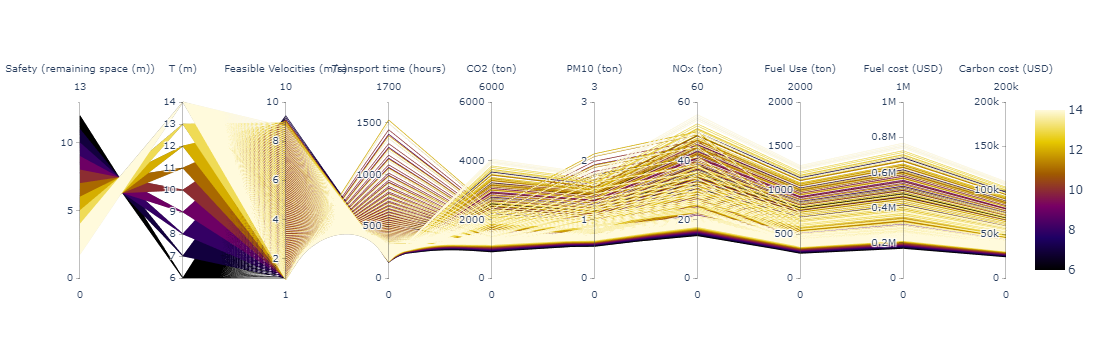

In [26]:

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = strategies_df['T_strategy'],
                   colorscale = 'Electric',
                   # colorscale = 'armyrose',
                   showscale = True,
                   cmin = 6,
                   cmax = 14),
        dimensions = list([
            dict(range = [0,13],
                 visible = True,
                 label = 'Safety (remaining space (m))', values = strategies_df['Safety (remaining space (m))']),
            dict(tickvals = [6,7,8,9,10,11,12,13,14],
                 ticktext = ['6','7','8','9','10','11','12','13','14'],
                 label = "T (m)", values = strategies_df['T_strategy']),
           
            dict(range = [1,10],
                 # constraintrange = [2,3.5],
                 label = "Feasible Velocities (m/s)", values = strategies_df['v_feasible']),                       
             dict(range = [0,1700],
                 label = 'Transport time (hours)', values = strategies_df['transport time (hours)']),
            dict(range = [0,6000],
                 label = 'CO2 (ton)', values = strategies_df['CO2 (ton)']),
            dict(range = [0,3],                
                 label = 'PM10 (ton)', values = strategies_df['PM10 (ton)']),
            dict(range = [0,60],                 
                 label = 'NOx (ton)', values = strategies_df['NOx (ton)']),
            dict(range = [0,2000],
                 # constraintrange = [8,20],
                 label = "Fuel Use (ton)", values = strategies_df['Fuel Use (ton)']),
            dict(range = [0,1000000],                 
                 label = 'Fuel cost (USD)', values = strategies_df['Fuel cost (MGO_600USD/ton)']),
            dict(range = [0,200000],
                 # constraintrange = [8,20],
                 label = 'Carbon cost (USD)', values = strategies_df['Carbon cost (EU_27USD/ton)']),            
           
        ]),
    )
)
fig.show()

In [25]:
# If you need to save this file as a standalone html file:
fig.write_html("C:/interactiveCharts/Strategies_dredging.html")